# SID: Learning to See in the Dark

### Imports

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

!pip install rawpy
import rawpy
import glob
from collections import defaultdict

In [2]:
print(tf.__version__)

2.17.1


## Prepare the Dataset: Nikon Low-Light RAW Image Dataset

In [3]:
def load_raw_image(path):
    """
    load a raw image and extract its Bayer array
    """
    with rawpy.imread(path) as raw:
        raw_img = raw.raw_image_visible.astype(np.float32)

    return raw_img

def pack_raw_image(raw_img):
    """
    convert a Bayer raw image into a 4-channel representation (R, G1, G2, B)

    example input (H, W, 1):  R   G1
                              G2  B

    output (H/2, W/2, 4):    R, G1, G2, B
    """
    H, W = raw_img.shape
    packed_img = np.zeros((H // 2, W // 2, 4), dtype=np.float32)

    packed_img[:,:,0] = raw_img[0::2, 0::2] # R top-left
    packed_img[:,:,1] = raw_img[0::2, 1::2] # G1 top-right
    packed_img[:,:,2] = raw_img[1::2, 0::2] # G2 bottom-left
    packed_img[:,:,3] = raw_img[1::2, 1::2] # B bottom-right

    return packed_img

def normalize_packed_image(packed_img):
    """
    generalized normalization based on the detected max pixel value
    """
    max_value = np.max(packed_img)
    if max_value > 0:
        packed_img /= max_value

    return packed_img

def plot_packed_image(packed_img):
    """
    plot packed image in 4 channels
    """
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    titles = ["Reds", "Greens", "Greens", "Blues"]

    for i in range(4):
        axes[i].imshow(packed_img[:,:,i], cmap=titles[i])
        axes[i].set_title(titles[i])
        axes[i].axis("off")
    plt.show()


In [4]:

def preprocess_raw_image(image_path):
    """
    preprocess the raw image
        - load
        - pack
        - normalize
    """
    if isinstance(image_path, bytes):
        image_path = image_path.decode("utf-8")
    raw_img = load_raw_image(image_path)
    packed_img = pack_raw_image(raw_img)
    packed_img = normalize_packed_image(packed_img)

    return packed_img


def preprocess_long_image(image_path):
    """
    load and convert a long-exposure raw image to RGB (3-channel)
    """
    if isinstance(image_path, bytes):
        image_path = image_path.decode("utf-8")
    with rawpy.imread(image_path) as raw:
        rgb_img = raw.postprocess(
            use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16
        )
        rgb_img = rgb_img.astype(np.float32) / 65535.0  # Normalize to [0,1]

    # resize long-exposure image to match short-exposure shape
    H, W = rgb_img.shape[:2]
    rgb_img_resized = cv2.resize(rgb_img, (W // 2, H // 2), interpolation=cv2.INTER_AREA)

    return rgb_img_resized


def load_and_process_pair(short_path, long_path):
    """
    load and process short, long paths

    Returns:
        (short-exposure, long-exposure) image pair
    """
    short_img = tf.numpy_function(preprocess_raw_image, [short_path], tf.float32)
    long_img = tf.numpy_function(preprocess_long_image, [long_path], tf.float32)

    short_img.set_shape([None, None, 4])  # 4-channel packed input
    long_img.set_shape([None, None, 3])

    return short_img, long_img


def create_tf_dataset(short_paths, long_paths, batch_size=1, training=True):
    """
    create a Tensorflow dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices((short_paths, long_paths))
    dataset = dataset.map(load_and_process_pair, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        dataset = dataset.batch(batch_size).shuffle(len(short_paths)).repeat()
    else:
        dataset = dataset.batch(batch_size)

    return dataset.prefetch(tf.data.AUTOTUNE)

In [5]:
def plot_paired_raw_image(short_raw_img, long_raw_img):
    """
    plot packed image in 4 channels
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    axes[0].imshow(short_raw_img, cmap="gray")
    axes[0].set_title("Short")
    axes[0].axis("off")

    axes[1].imshow(long_raw_img, cmap="gray")
    axes[1].set_title("Long")
    axes[1].axis("off")
    plt.show()

In [5]:
short_image_path = "/kaggle/input/nikon-camera-dataset/short/00004_04_0.10000s.NEF"
short_raw_img = load_raw_image(short_image_path)

long_image_path = "/kaggle/input/nikon-camera-dataset/long/00004_00_30s.NEF"
long_raw_img = load_raw_image(long_image_path)

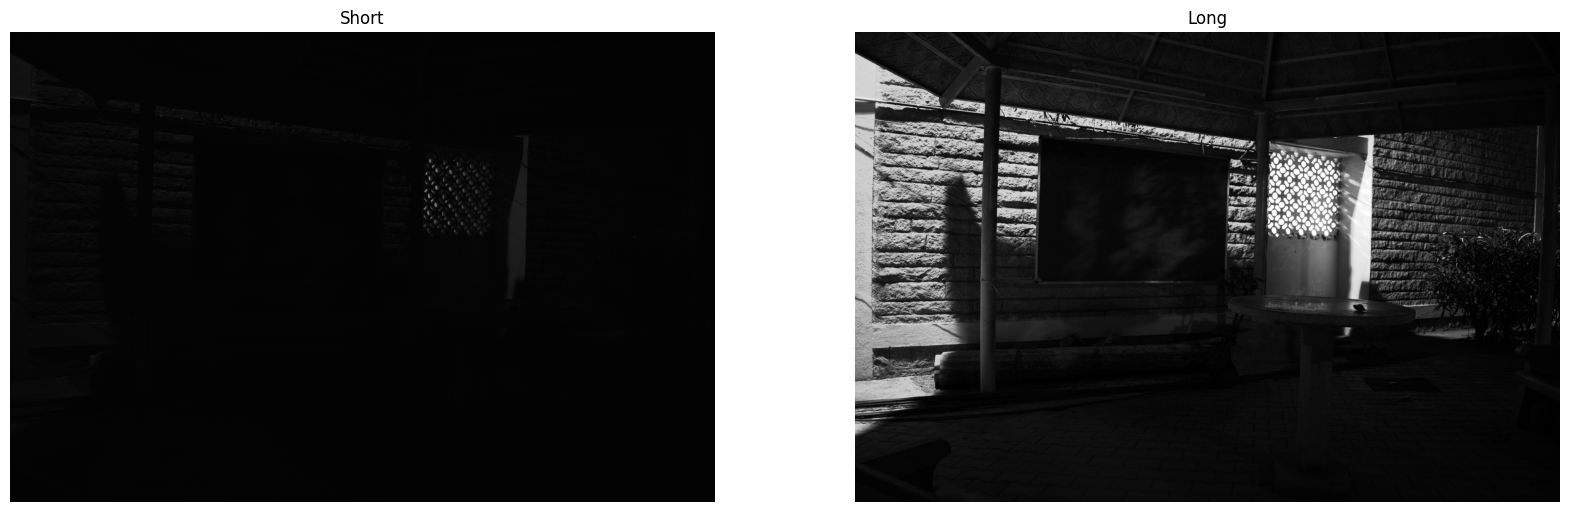

In [25]:
plot_paired_raw_image(short_raw_img, long_raw_img)

In [26]:
short_packed_img = preprocess_raw_image(short_image_path)
long_packed_img = preprocess_raw_image(long_image_path)

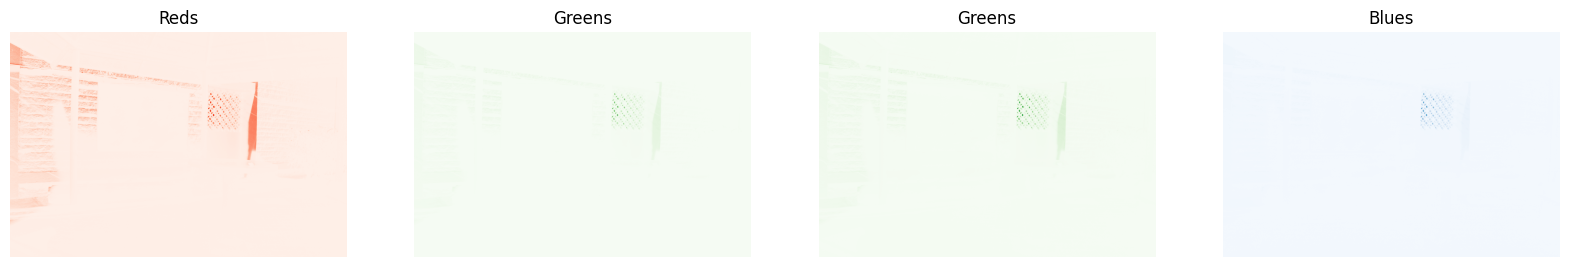

In [27]:
plot_packed_image(short_packed_img)

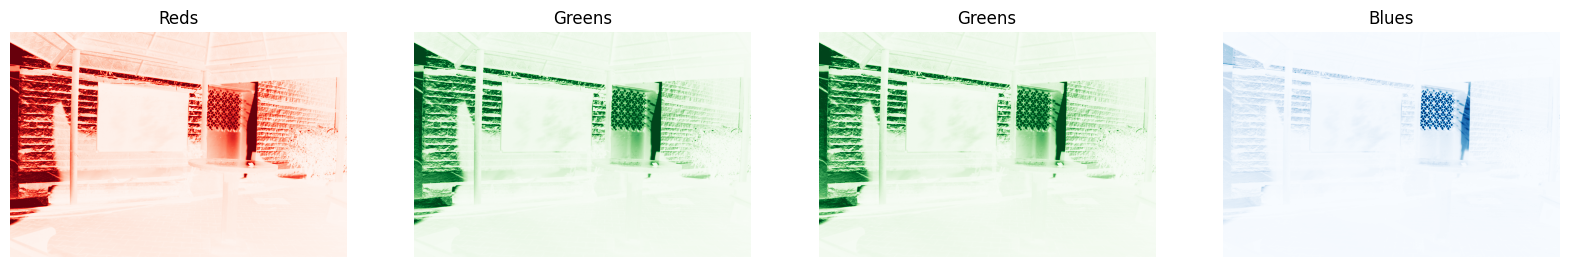

In [28]:
plot_packed_image(long_packed_img)

#### EDA

- long-exposure images: `{scene_id}_{iso}_{shutter_speed}`
- short-exposure images: `{scene_id}_{variant}_{shutter_speed}`

In [6]:
long_dataset_path = "/kaggle/input/nikon-camera-dataset/long"
short_dataset_path = "/kaggle/input/nikon-camera-dataset/short"

# get all NEF image paths
long_image_paths = sorted(glob.glob(long_dataset_path + "/*.NEF"))
short_image_paths = sorted(glob.glob(short_dataset_path + "/*.NEF"))

print(len(long_image_paths), len(short_image_paths))

65 77


In [9]:
!ls "/kaggle/input/nikon-camera-dataset/long"

00004_00_30s.NEF       00021_00_30s.NEF  00041_01_30s.NEF  00059_01_10s.NEF
00005_01_10s.NEF       00022_01_10s.NEF  00042_02_10s.NEF  00060_02_5s.NEF
00006_02_5s.NEF        00023_02_5s.NEF	 00044_00_30s.NEF  10001_01_30s.NEF
00007_09_30s.NEF       00024_00_5s.NEF	 00045_01_10s.NEF  10002_02_10s.NEF
00008_08_10s.NEF       00025_00_30s.NEF  00046_00_30s.NEF  10003_03_5s.NEF
00009_07_5s.NEF        00026_01_10s.NEF  00047_01_10s.NEF  10034_00_30s.NEF
00010_00_30s.NEF       00027_02_5s.NEF	 00048_00_30s.NEF  10035_01_10s.NEF
00011_01_10s.NEF       00028_00_10s.NEF  00049_01_10s.NEF  10036_02_5s.NEF
00012_02_5s.NEF        00029_01_5s.NEF	 00050_02_5s.NEF   10061_00_30s.NEF
00013_00_0.50000s.NEF  00030_01_30s.NEF  00051_00_30s.NEF  10062_01_10s.NEF
00014_00_30s.NEF       00031_02_10s.NEF  00052_01_10s.NEF  10063_02_5s.NEF
00015_01_10s.NEF       00032_03_5s.NEF	 00053_02_5s.NEF   10064_00_30s.NEF
00016_02_5s.NEF        00033_00_10s.NEF  00054_00_30s.NEF  10065_01_10s.NEF
00017_02_0.50000s.NEF

In [10]:
!ls "/kaggle/input/nikon-camera-dataset/short"

00004_04_0.10000s.NEF  00030_05_0.10000s.NEF  00060_07_0.01667s.NEF
00005_06_0.03333s.NEF  00031_07_0.03333s.NEF  10001_04_0.33333s.NEF
00006_05_0.05000s.NEF  00032_06_0.05000s.NEF  10001_05_0.10000s.NEF
00007_05_0.10000s.NEF  00033_01_0.10000s.NEF  10002_05_0.10000s.NEF
00008_05_0.10000s.NEF  00037_06_0.33333s.NEF  10002_07_0.03333s.NEF
00009_04_0.05000s.NEF  00038_05_0.03333s.NEF  10003_06_0.05000s.NEF
00010_04_0.10000s.NEF  00039_02_0.10000s.NEF  10003_08_0.01667s.NEF
00011_06_0.03333s.NEF  00040_07_0.01667s.NEF  10034_03_0.33333s.NEF
00012_07_0.01667s.NEF  00041_04_0.10000s.NEF  10034_04_0.10000s.NEF
00013_02_0.00156s.NEF  00042_06_0.03333s.NEF  10035_04_0.10000s.NEF
00014_04_0.10000s.NEF  00044_03_0.10000s.NEF  10035_06_0.03333s.NEF
00015_04_0.10000s.NEF  00045_04_0.03333s.NEF  10036_05_0.05100s.NEF
00016_05_0.05000s.NEF  00046_02_0.33333s.NEF  10036_07_0.01667s.NEF
00017_01_0.00500s.NEF  00047_04_0.03333s.NEF  10061_03_0.33333s.NEF
00018_04_0.10000s.NEF  00048_04_0.10000s.NEF  10

In [7]:
short_image_dct = defaultdict(list)

for path in short_image_paths:
    filename = path.split("/")[-1]
    scene_id = filename.split("_")[0]
    short_image_dct[scene_id].append(path)

# for scene, images in short_image_dct.items():
#     print(scene, len(images))

In [8]:
short_image_lst = []
long_image_lst = []

for long_path in long_image_paths:
    filename = long_path.split("/")[-1]
    scene_id = filename.split("_")[0]

    if scene_id in short_image_dct:
        for short_path in short_image_dct[scene_id]:
            short_image_lst.append(short_path)
            long_image_lst.append(long_path)
    else:
        print(scene_id)

print(len(long_image_lst), len(short_image_lst))

77 77


In [9]:
x_train, x_val, y_train, y_val = train_test_split(short_image_lst, long_image_lst, test_size=0.1, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.05, random_state=42)

print ("x_train shape: ", len(x_train))
print ("y_train shape: ", len(y_train))
print ("x_val shape: ", len(x_val))
print ("y_val shape: ", len(y_val))
print ("x_test shape: ", len(x_test))
print ("y_test shape: ", len(y_test))

x_train shape:  65
y_train shape:  65
x_val shape:  8
y_val shape:  8
x_test shape:  4
y_test shape:  4


In [10]:
train_dataset = create_tf_dataset(x_train, y_train)
val_dataset = create_tf_dataset(x_val, y_val, training=False)
test_dataset = create_tf_dataset(x_test, y_test, training=False)


# for short_img, long_img in train_dataset.take(1):
#     print("Short Image Shape:", short_img.shape)
#     print("Long Image Shape:", long_img.shape)

In [21]:
def check_dataset_shapes(dataset):
    unique_shapes_short = set()
    unique_shapes_long = set()

    for short_img, long_img in dataset:
        unique_shapes_short.add(tuple(short_img.shape))
        unique_shapes_long.add(tuple(long_img.shape))

    print("Unique short image shapes:", unique_shapes_short)
    print("Unique long image shapes:", unique_shapes_long)


In [24]:
check_dataset_shapes(train_dataset)

Unique short image shapes: {(2, 2008, 3008, 4), (1, 2008, 3008, 4)}
Unique long image shapes: {(2, 2008, 3008, 3), (1, 2008, 3008, 3)}


In [22]:
check_dataset_shapes(val_dataset)

Unique short image shapes: {(2, 2008, 3008, 4)}
Unique long image shapes: {(2, 2008, 3008, 3)}


In [23]:
check_dataset_shapes(test_dataset)

Unique short image shapes: {(2, 2008, 3008, 4)}
Unique long image shapes: {(2, 2008, 3008, 3)}


## Define the Model

In [11]:
def sid(input_shape=(None, None, 4)):
    """
    SID model using a Fully Convolutional Network
    """

    inputs = tf.keras.layers.Input(shape=input_shape)

    # encoder - downsampling
    x = tf.keras.layers.Conv2D(32, (3, 3), padding="same", strides=1, activation="relu")(inputs)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", strides=2, activation="relu")(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding="same", strides=2, activation="relu")(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding="same", strides=2, activation="relu")(x)

    # bottleneck
    x = tf.keras.layers.Conv2D(12, (3, 3), padding="same", activation="relu")(x)

    # decoder - upsampling
    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), padding="same", strides=2, activation="relu")(x)
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), padding="same", strides=2, activation="relu")(x)
    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), padding="same", strides=2, activation="relu")(x)

    # output RGB image
    x = tf.keras.layers.Conv2D(3, (3, 3), padding="same", strides=1, activation="sigmoid")(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=x, name="SID")

    return model

In [12]:
model = sid()
model.build(input_shape=(None, None, None, 4))
model.summary()

Model: "SID"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, None, None, 32)      │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, None, None, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, None, None, 12)      │          27,660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, None, None, 128)     │          13,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, None, None, 64)      │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, None, None, 32)      │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, None, None, 3)       │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 523,439 (2.00 MB)

 Trainable params: 523,439 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the Model

In [13]:
def charbonnier_loss(y_true, y_pred, eps=1e-3):
    """
    charbonnier loss, smooth L1 loss
    """
    diff = y_true - y_pred
    loss = K.mean(K.sqrt(diff ** 2 + eps ** 2))

    return loss

def ssim_loss(y_true, y_pred):
    """
    SSIM-based perceptual loss (1 - Structural Similarity)
    """
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=charbonnier_loss,
    metrics=[ssim_loss]
)

### Train the Model

In [15]:
checkpoint_path = "/checkpoints/sid.weights.h5"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# model.load_weights("/checkpoints/sid.weights.h5")

Num GPUs Available:  1


In [16]:
EPOCHS = 10
BATCH_SIZE = 1

train_length = len(x_train)
val_length = len(x_val)

val_subsplits = 1
steps_per_epoch = train_length // BATCH_SIZE
validation_steps = val_length // BATCH_SIZE // val_subsplits

In [17]:
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3285 - ssim_loss: 0.5620
Epoch 1: val_loss improved from inf to 0.28169, saving model to /checkpoints/sid.weights.h5
65/65 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - loss: 0.3286 - ssim_loss: 0.5628 - val_loss: 0.2817 - val_ssim_loss: 0.8657
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - loss: 0.2186 - ssim_loss: 0.8234
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2345 - ssim_loss: 0.8153
Epoch 3: val_loss improved from 0.28169 to 0.24059, saving model to /checkpoints/sid.weights.h5
65/65 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - loss: 0.2339 - ssim_loss: 0.8150 - val_loss: 0.2406 - val_ssim_loss: 0.7616
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - loss: 0.2337 - ssim_loss: 0.7973
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1617 - ssim_loss: 0.7866
Epoch 5: val_loss improved from 0.24059 to 0.23930, saving model to /checkpoints/sid.weights.h5
65/65 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - loss: 0.1622 - ssim_loss: 0.7869 - val_loss: 0.2393 - val_ssim_loss: 0.7721
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - loss: 0.1904 - ssim_loss: 0.7634
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1824 - ssim_loss: 0.7551
Epoch 7: val_loss improved from 0.23930 to 0.23827, saving model to /checkpoints/sid.weights.h5
65/65 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - loss: 0.1826 - ssim_l

### Evaluate the Model

In [19]:
test_loss = model.evaluate(test_dataset, steps=len(x_test) // BATCH_SIZE, verbose=2)
print(f"Test Loss: {test_loss}")

4/4 - 9s - 2s/step - loss: 0.3322 - ssim_loss: 0.7840
Test Loss: [0.33215707540512085, 0.7840115427970886]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


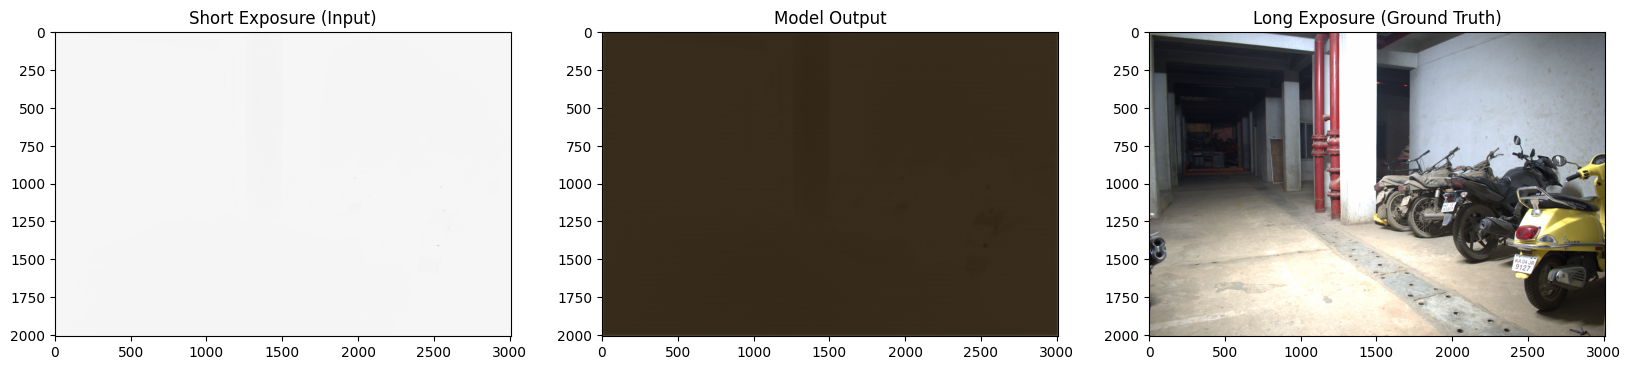

In [21]:
for short_img, long_img in test_dataset.take(1):
    pred_img = model.predict(short_img)

    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    # first sample in batch
    axes[0].imshow(short_img[0])
    axes[0].set_title("Short Exposure (Input)")

    axes[1].imshow(pred_img[0])
    axes[1].set_title("Model Output")

    axes[2].imshow(long_img[0])
    axes[2].set_title("Long Exposure (Ground Truth)")

    plt.show()
    break

#### Compute SSIM and PSNR Scores

- SSIM: Structural Similarity Index, close to 1.0 means high structural similarity
- PSNR: Peak Signal-to-Noise Ratio, above 25 dB is generally good

In [22]:
ssim_scores = []
psnr_scores = []

for short_img, long_img in test_dataset:
    pred_img = model.predict(short_img)

    ssim_score = tf.image.ssim(pred_img, long_img, max_val=1.0).numpy().mean()
    psnr_score = tf.image.psnr(pred_img, long_img, max_val=1.0).numpy().mean()

    ssim_scores.append(ssim_score)
    psnr_scores.append(psnr_score)


print(f"Average SSIM: {sum(ssim_scores) / len(ssim_scores):.4f}")
print(f"Average PSNR: {sum(psnr_scores) / len(psnr_scores):.2f} dB")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Average SSIM: 0.2160
Average PSNR: 9.55 dB
